In [3]:
import pandas as pd
import numpy as np


df_weight = pd.read_csv('df_weight')
df_weight.head()

,4-aminobenzoic acid,aclarubicin,adenosine triphosphate,alfentanil,aluminum hydroxide,mitomycin,ammonium chloride,belladonna alkaloids,boric acid,calcium phosphate,...,EYE,CONG,METAB,BLOOD,STAT,DEV,MENTAL,HEARING,ID,Label
0,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.029630
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.045685
2,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015936
3,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,-0.102639
4,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.117073


In [3]:
df_weight.shape

(3555, 3128)

In [2]:
'''
Gradient Boosting Classifier - 10% Weight loss search
'''

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

n_estimators = [25, 50, 100, 200]
learning_rates = [0.01, 0.05, 0.03, 0.1, 0.2]
max_depths = [2,3,4,5,6]



def fit_gbr(df_weight, n_est, lr, md):
    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)

    y = df_weight.iloc[:,-1]
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)

    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, random_state=42)  

    gbr_clf = GradientBoostingClassifier(n_estimators=n_est, max_depth=md, learning_rate=lr, random_state=2)
    gbr_clf.fit(X_train, y_train)

    y_pred = gbr_clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)


    # predict probabilities
    gbr_probs = gbr_clf.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    gbr_probs = gbr_probs[:, 1]

    # calculate scores
    gbr_auc = roc_auc_score(y_test, gbr_probs)

    # summarize scores
    print('Gradient Boosting: ROC AUC=%.3f' % (gbr_auc))
    
    return gbr_auc

aucs = []
params = []

for n_est in n_estimators:
    for lr in learning_rates:
        for md in max_depths:
            gbr_auc = fit_gbr(df_weight, n_est, lr, md)
            params.append([n_est, lr, md])
            aucs.append(gbr_auc)
            
print('max_auc: ', max(aucs))
aucs = np.array(aucs)
print('best parameters: ', params[np.argmax(aucs)])  

Gradient Boosting: ROC AUC=0.612
Gradient Boosting: ROC AUC=0.607
Gradient Boosting: ROC AUC=0.618
Gradient Boosting: ROC AUC=0.617
Gradient Boosting: ROC AUC=0.619
Gradient Boosting: ROC AUC=0.620
Gradient Boosting: ROC AUC=0.629
Gradient Boosting: ROC AUC=0.628
Gradient Boosting: ROC AUC=0.619
Gradient Boosting: ROC AUC=0.618
Gradient Boosting: ROC AUC=0.619
Gradient Boosting: ROC AUC=0.620
Gradient Boosting: ROC AUC=0.628
Gradient Boosting: ROC AUC=0.632
Gradient Boosting: ROC AUC=0.621
Gradient Boosting: ROC AUC=0.613
Gradient Boosting: ROC AUC=0.623
Gradient Boosting: ROC AUC=0.613
Gradient Boosting: ROC AUC=0.623
Gradient Boosting: ROC AUC=0.605
Gradient Boosting: ROC AUC=0.606
Gradient Boosting: ROC AUC=0.613
Gradient Boosting: ROC AUC=0.609
Gradient Boosting: ROC AUC=0.624
Gradient Boosting: ROC AUC=0.585
Gradient Boosting: ROC AUC=0.616
Gradient Boosting: ROC AUC=0.627
Gradient Boosting: ROC AUC=0.630
Gradient Boosting: ROC AUC=0.635
Gradient Boosting: ROC AUC=0.627
Gradient B

In [7]:
'''
Implementing the Repeated Cross-Validations - 10% loss
'''
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings('ignore')

def write_shap_dict(df_weight):
    '''
    Function to write the empty dictionary for the SHAP values
    '''
    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() < 10], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)

    
    np.random.seed(31)
    CV_repeats = 10

    # Make a list of random integers between 0 and 10000 of length = CV_repeats to act as different data splits
    random_states = np.random.randint(10000, size=CV_repeats) 

    #Dictionary to keep track of the SHAP values of each observation per CV repition
    shap_values_per_cv = {}
    for sample in X.index:
        #create keys for each sample
        shap_values_per_cv[sample] = {}
        #keys for each CV fold within each sample
        for CV_repeat in range(CV_repeats):
            shap_values_per_cv[sample][CV_repeat] = {}
            
    return shap_values_per_cv, random_states
            
shap_values_per_cv, random_states = write_shap_dict(df_weight)

def gbr_cv(df_weight, n_est, lr, md, shap_values_per_cv, random_states):
    '''
    Performing the Cross-Validation
    '''

    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y = pd.DataFrame(y)
    
    CV_repeats=10

    for i, CV_repeat in enumerate(range(CV_repeats)):
        #Verbose 
        print('\n------------ CV Repeat number:', CV_repeat)

        #Cross-Validations
        CV = KFold(n_splits=5, shuffle=True, random_state = random_states[i])
        ix_training, ix_test = [], []

        #Loop through the CV fold and put the train and test indices into the empty lists above
        for fold in CV.split(df_weight):
            ix_training.append(fold[0])
            ix_test.append(fold[1])
        
        #Loop through outer folds and extract SHAP values
        for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)):
            #Verbose
            print('\n------ Fold Number:',i)

            X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
            y_train, y_test = y.iloc[train_outer_ix], y.iloc[test_outer_ix] #Potential fix for the type of y here


            model = GradientBoostingClassifier(n_estimators=n_est, max_depth=md, learning_rate=lr, random_state=2)
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
                
            # predict probabilities
            gbr_probs = model.predict_proba(X_test)
            # keep probabilities for the positive outcome only
            gbr_probs = gbr_probs[:, 1]
            
            # calculate scores
            gbr_auc = roc_auc_score(y_test, gbr_probs)

            # summarize scores
            print('Gradient Boosting: ROC AUC=%.3f' % (gbr_auc))

            # Use SHAP to explain predictions
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)

            # Extract SHAP information per fold per sample 
            for i, test_index in enumerate(test_outer_ix):
                shap_values_per_cv[test_index][CV_repeat] = shap_values[i] #-#-#
                
    return shap_values_per_cv

shap_values_per_cv = gbr_cv(df_weight, 50, 0.01, 5, shap_values_per_cv, random_states)


------------ CV Repeat number: 0

------ Fold Number: 0
Gradient Boosting: ROC AUC=0.611

------ Fold Number: 1
Gradient Boosting: ROC AUC=0.592

------ Fold Number: 2
Gradient Boosting: ROC AUC=0.598

------ Fold Number: 3
Gradient Boosting: ROC AUC=0.586

------ Fold Number: 4
Gradient Boosting: ROC AUC=0.560

------------ CV Repeat number: 1

------ Fold Number: 0
Gradient Boosting: ROC AUC=0.550

------ Fold Number: 1
Gradient Boosting: ROC AUC=0.617

------ Fold Number: 2
Gradient Boosting: ROC AUC=0.612

------ Fold Number: 3
Gradient Boosting: ROC AUC=0.597

------ Fold Number: 4
Gradient Boosting: ROC AUC=0.595

------------ CV Repeat number: 2

------ Fold Number: 0
Gradient Boosting: ROC AUC=0.609

------ Fold Number: 1
Gradient Boosting: ROC AUC=0.627

------ Fold Number: 2
Gradient Boosting: ROC AUC=0.575

------ Fold Number: 3
Gradient Boosting: ROC AUC=0.601

------ Fold Number: 4
Gradient Boosting: ROC AUC=0.578

------------ CV Repeat number: 3

------ Fold Number: 0
G

Text(0.5, 1.0, 'Average SHAP values after 10x cross-validation')

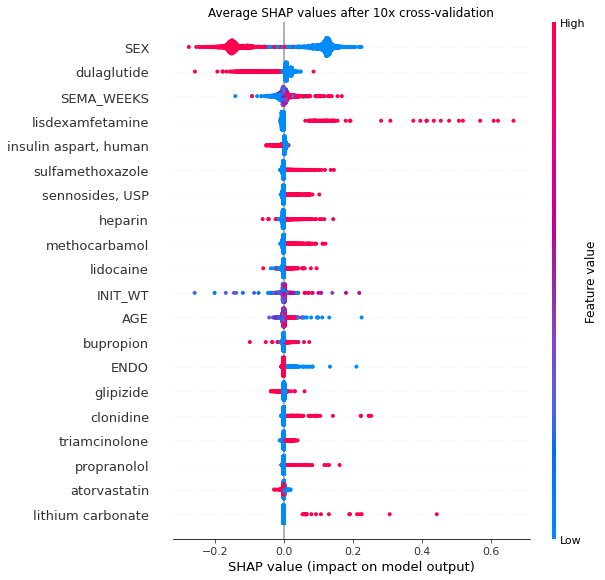

In [8]:
'''
Getting the Shap Plots of the average values from the Cross-Validations
'''
X = df_weight.iloc[:,:-1]
X = X.drop(X.columns[X.sum() == 0], axis=1)
y = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
y = pd.DataFrame(y)

average_shap_values, stds, ranges = [], [], []

for i in range(0, len(df_weight)):
    # Get all SHAP values for sample number i
    df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) 
    # Get relevant statistics for every sample 
    average_shap_values.append(df_per_obs.mean(axis=1).values) 
    stds.append(df_per_obs.std(axis=1).values)
    ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)


shap.summary_plot(np.array(average_shap_values), X, show = False)
plt.title('Average SHAP values after 10x cross-validation')